In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import os
from tqdm import tqdm
import seaborn as sns
sns.set()

In [2]:
# define dataset inputs

csvPath = '/Users/haidiazaman/Desktop/dsa5206-project/data/jena_climate_2009_2016.csv'
batch_size = 512
train_size,val_size,test_size = 0.7,0.2,0.1
lookback = 10
date_col_name = 'Date Time'
value_col_names = [
    'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
    'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
    'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
    'wd (deg)'
]

target_variable = 'T (degC)'

In [25]:
# define model inputs


input_size = 3
hidden_size=1
num_stacked_layers=1
lr=0.001
epochs = 10

scheduler_factor=0.5
scheduler_patience=3

early_stopping_limit = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dimensionality Reduction - PCA

In [4]:
from sklearn.decomposition import PCA

In [5]:
full_data = pd.read_csv(csvPath)
full_data[date_col_name] = pd.to_datetime(full_data[date_col_name])
full_data = full_data[
    ['Date Time', 'T (degC)', 'p (mbar)', 'Tpot (K)', 'Tdew (degC)',
    'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
    'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
    'wd (deg)']
] #rearrange columns to put target variable first

In [6]:
full_data

,Date Time,T (degC),p (mbar),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,-8.02,996.52,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,-8.41,996.57,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,-8.51,996.53,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,-8.31,996.51,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,-8.27,996.51,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,2016-12-31 23:20:00,-4.05,1000.07,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,2016-12-31 23:30:00,-3.35,999.93,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,2016-12-31 23:40:00,-3.16,999.82,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,2016-12-31 23:50:00,-4.23,999.81,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


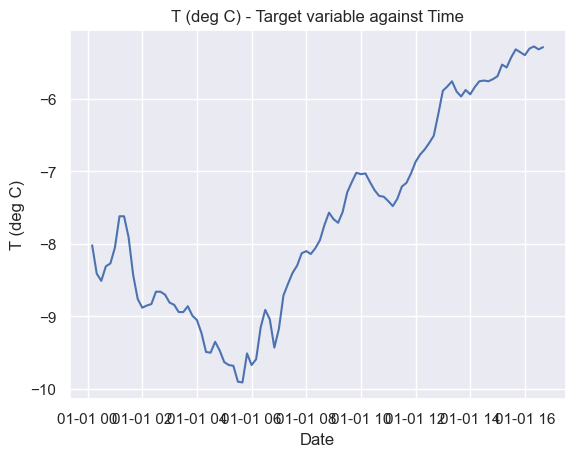

In [7]:
plt.plot(full_data[date_col_name][:100],full_data[target_variable][:100])
plt.title('T (deg C) - Target variable against Time')
plt.ylabel('T (deg C)')
plt.xlabel('Date')
plt.show()

In [8]:
# normalize the data before PCA

scaler = MinMaxScaler(feature_range=(-1, 1))
full_data_numpy = full_data.to_numpy()[:,1:] # ignore datetime column
scaled_full_data = scaler.fit_transform(full_data_numpy)
X = scaled_full_data

In [9]:
# normalize the data before PCA

scaler = MinMaxScaler(feature_range=(-1, 1))
target_data_numpy = full_data[target_variable].to_numpy()
scaled_target_data = scaler.fit_transform(target_data_numpy.reshape(-1,1))
y = scaled_target_data

In [10]:
X.shape,y.shape

((420551, 14), (420551, 1))

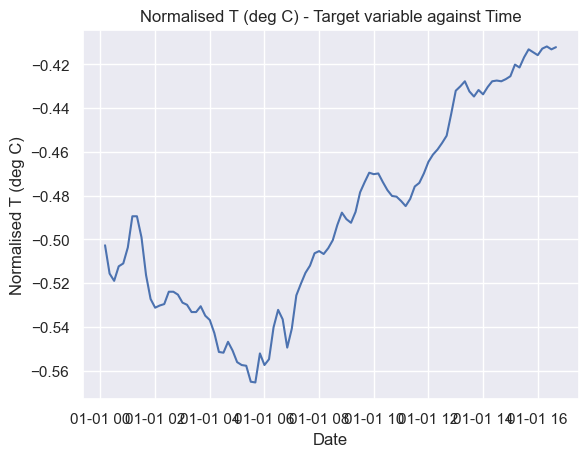

In [11]:
plt.plot(full_data[date_col_name][:100],y[:100])
plt.title('Normalised T (deg C) - Target variable against Time')
plt.ylabel('Normalised T (deg C)')
plt.xlabel('Date')
plt.show()

In [12]:
pca = PCA(n_components=3)  # we shall just plot the top 2 components
X_pca = pca.fit_transform(X)
X_pca.shape

(420551, 3)

In [13]:
pca.explained_variance_ratio_,sum(pca.explained_variance_ratio_)

(array([0.57893844, 0.21588031, 0.16015444]), 0.954973195327443)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


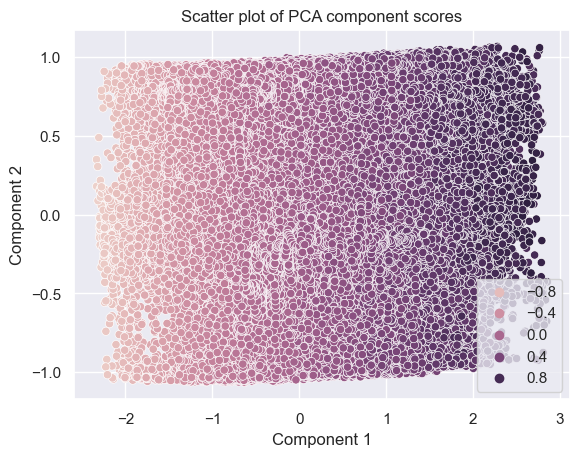

In [14]:
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], legend=True, hue=y.reshape(-1)) 
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of PCA component scores')
plt.savefig('PCA.png')

# Dataset
- preprocess dataset 
    - format into df with lookback window
    - normalize features
    - train val test split

In [15]:
# define dataloader class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    

# format df into df with lookback window
def prepare_shifted_df(df, n_steps, date_col_name, value_col_name):
    df = dc(df)
    df.set_index(date_col_name, inplace=True)
    for i in range(1, n_steps+1):
        df[f'{value_col_name}(t-{i})'] = df[value_col_name].shift(i)
    df.dropna(inplace=True)
    return df


def process_shifted_df(shifted_df,lookback):
    # format X and y from df and scale it
    shifted_df_as_np = shifted_df.to_numpy()
    # print(shifted_df_as_np.shape)

    # normalise the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    # print(X.shape, y.shape)
    X = dc(np.flip(X, axis=1))
    
    X = X.reshape(-1,lookback,1)
    y = y.reshape(-1,1)
    return X,y

In [16]:
X_pca_df = pd.DataFrame(X_pca, columns=['component 1','component 2','component 3'])
X_pca_df['Date Time'] = full_data['Date Time']
X_pca_df = X_pca_df[['Date Time','component 1','component 2','component 3']]
X_pca_df

,Date Time,component 1,component 2,component 3
0,2009-01-01 00:10:00,-1.485356,0.096120,-0.039055
1,2009-01-01 00:20:00,-1.513885,0.185791,-0.037769
2,2009-01-01 00:30:00,-1.515713,-0.011359,-0.042149
3,2009-01-01 00:40:00,-1.498260,-0.157825,-0.048359
4,2009-01-01 00:50:00,-1.493056,-0.248165,-0.044780
...,...,...,...,...
420546,2016-12-31 23:20:00,-1.207659,-0.377174,0.366052
420547,2016-12-31 23:30:00,-1.161546,-0.343646,0.433819
420548,2016-12-31 23:40:00,-1.151967,-0.236830,0.470532
420549,2016-12-31 23:50:00,-1.221537,-0.298100,0.396447


In [17]:
y_df = pd.DataFrame(y, columns=[f'normalised {target_variable}'])
y_df['Date Time'] = full_data['Date Time']
y_df = y_df[['Date Time',f'normalised {target_variable}']]
y_df

,Date Time,normalised T (degC)
0,2009-01-01 00:10:00,-0.502737
1,2009-01-01 00:20:00,-0.515674
2,2009-01-01 00:30:00,-0.518992
3,2009-01-01 00:40:00,-0.512357
4,2009-01-01 00:50:00,-0.511030
...,...,...
420546,2016-12-31 23:20:00,-0.371040
420547,2016-12-31 23:30:00,-0.347819
420548,2016-12-31 23:40:00,-0.341516
420549,2016-12-31 23:50:00,-0.377011


In [19]:
date_col_name = 'Date Time'

value_col_name =  'component 1'
data = X_pca_df[[date_col_name,value_col_name]]
shifted_df = prepare_shifted_df(data, lookback, date_col_name, value_col_name)
X,_ = process_shifted_df(shifted_df,lookback)

value_col_name =  'component 2'
data = X_pca_df[[date_col_name,value_col_name]]
shifted_df = prepare_shifted_df(data, lookback, date_col_name, value_col_name)
X_,_ = process_shifted_df(shifted_df,lookback)

X = np.concatenate((X,X_),axis=2)   

value_col_name =  'component 3'
data = X_pca_df[[date_col_name,value_col_name]]
shifted_df = prepare_shifted_df(data, lookback, date_col_name, value_col_name)
X_,_ = process_shifted_df(shifted_df,lookback)

X = np.concatenate((X,X_),axis=2)   


value_col_name =  f'normalised {target_variable}'
data = y_df[[date_col_name,value_col_name]]
shifted_df = prepare_shifted_df(data, lookback, date_col_name, value_col_name)
_,y = process_shifted_df(shifted_df,lookback)

X.shape,y.shape

((420541, 10, 3), (420541, 1))

In [20]:
# train test split
X_train = X[:int(len(X) * train_size)]
X_val = X[int(len(X) * train_size):int(len(X) * train_size)+int(len(X) * val_size)]
X_test = X[int(len(X) * train_size)+int(len(X) * val_size):]
print(X_train.shape, X_val.shape, X_test.shape)
y_train = y[:int(len(y) * train_size)]
y_val = y[int(len(y) * train_size):int(len(y) * train_size)+int(len(y) * val_size)]
y_test = y[int(len(y) * train_size)+int(len(y) * val_size):]
print(y_train.shape, y_val.shape, y_test.shape)

# convert to torch tensor
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()
print(X_train.shape, X_val.shape, X_test.shape)
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()
y_test = torch.tensor(y_test).float()
print(y_train.shape, y_val.shape, y_test.shape)

(294378, 10, 3) (84108, 10, 3) (42055, 10, 3)
(294378, 1) (84108, 1) (42055, 1)
torch.Size([294378, 10, 3]) torch.Size([84108, 10, 3]) torch.Size([42055, 10, 3])
torch.Size([294378, 1]) torch.Size([84108, 1]) torch.Size([42055, 1])


In [21]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # set all shuffle=False since its sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [22]:
# print to check
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([512, 10, 3]) torch.Size([512, 1])


# Define Models

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0) # input must be torch tensor
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # short term memory
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # long term memory

        out, _ = self.lstm(x, (h0, c0)) # output is output, (h_n, c_n), but we dont need to track the next state h1,c1 as the model does it for us
        # out shape is (batch_size, num_timesteps inclusive of predicted day, num_features_in_hidden_state)
        out = self.fc(out[:, -1, :]) # -1 to take the final value of the time series, this is the prediction for the current timestep, changes if dataset format is different, e.g. target at the end instead
        return out


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # rnn only has h0 short term memory, no c0 long term memory

        out, _ = self.rnn(x, h0) # output is (output, h_n) but dont need to manually keep track of the next h1, model does it for us
        out = self.fc(out[:, -1, :]) # -1 to take the final value of the time series, this is the prediction for the current timestep, changes if dataset format is different, e.g. target at the end instead
        return out


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # gru only has h0 memory, no c0 long term memory

        out, _ = self.gru(x, h0) # output is (output, h_n) but dont need to manually keep track of the next h1, model does it for us
        out = self.fc(out[:, -1, :]) # -1 to take the final value of the time series, this is the prediction for the current timestep, changes if dataset format is different, e.g. target at the end instead
        return out

# RNN - train

In [26]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()
model = RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

epochs = epochs
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]


for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'rnn.pt')
        print(f'model epoch {epoch} saved as rnn.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= early_stopping_limit:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

epoch 0
model epoch 0 saved as rnn.pt
Epoch 1/10, train loss: 0.1094, val loss: 0.0630, time_taken: 2.3
epoch 1
model epoch 1 saved as rnn.pt
Epoch 2/10, train loss: 0.0764, val loss: 0.0489, time_taken: 2.0
epoch 2
model epoch 2 saved as rnn.pt
Epoch 3/10, train loss: 0.0473, val loss: 0.0147, time_taken: 2.1
epoch 3
model epoch 3 saved as rnn.pt
Epoch 4/10, train loss: 0.0104, val loss: 0.0020, time_taken: 2.2
epoch 4
model epoch 4 saved as rnn.pt
Epoch 5/10, train loss: 0.0044, val loss: 0.0015, time_taken: 2.0
epoch 5
model epoch 5 saved as rnn.pt
Epoch 6/10, train loss: 0.0035, val loss: 0.0013, time_taken: 2.0
epoch 6
model epoch 6 saved as rnn.pt
Epoch 7/10, train loss: 0.0029, val loss: 0.0012, time_taken: 2.1
epoch 7
model epoch 7 saved as rnn.pt
Epoch 8/10, train loss: 0.0024, val loss: 0.0011, time_taken: 2.0
epoch 8
model epoch 8 saved as rnn.pt
Epoch 9/10, train loss: 0.0021, val loss: 0.0011, time_taken: 2.0
epoch 9
model epoch 9 saved as rnn.pt
Epoch 10/10, train loss: 0

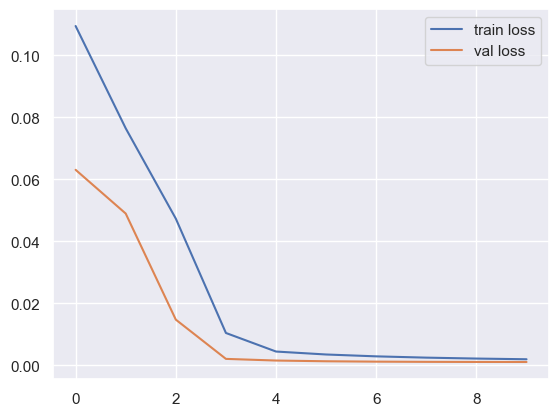

In [27]:
# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.legend()
plt.show()

# LSTM - train

In [35]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()
model = LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

epochs = epochs
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]


for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'lstm.pt')
        print(f'model epoch {epoch} saved as lstm.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= early_stopping_limit:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

epoch 0
model epoch 0 saved as lstm.pt
Epoch 1/10, train loss: 0.1569, val loss: 0.0460, time_taken: 2.7
epoch 1
model epoch 1 saved as lstm.pt
Epoch 2/10, train loss: 0.0477, val loss: 0.0247, time_taken: 2.6
epoch 2
model epoch 2 saved as lstm.pt
Epoch 3/10, train loss: 0.0244, val loss: 0.0085, time_taken: 2.6
epoch 3
model epoch 3 saved as lstm.pt
Epoch 4/10, train loss: 0.0089, val loss: 0.0039, time_taken: 2.6
epoch 4
model epoch 4 saved as lstm.pt
Epoch 5/10, train loss: 0.0049, val loss: 0.0030, time_taken: 2.7
epoch 5
model epoch 5 saved as lstm.pt
Epoch 6/10, train loss: 0.0035, val loss: 0.0024, time_taken: 2.9
epoch 6
model epoch 6 saved as lstm.pt
Epoch 7/10, train loss: 0.0026, val loss: 0.0019, time_taken: 2.7
epoch 7
model epoch 7 saved as lstm.pt
Epoch 8/10, train loss: 0.0020, val loss: 0.0015, time_taken: 2.6
epoch 8
model epoch 8 saved as lstm.pt
Epoch 9/10, train loss: 0.0016, val loss: 0.0012, time_taken: 2.7
epoch 9
model epoch 9 saved as lstm.pt
Epoch 10/10, tra

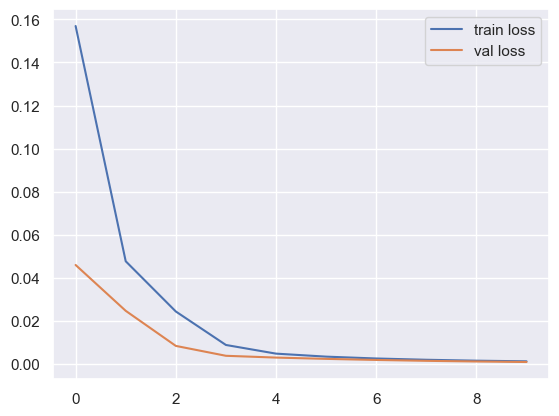

In [36]:
# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.legend()
plt.show()

# GRU - train

In [30]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()
model = GRU(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

epochs = epochs
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]


for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'gru.pt')
        print(f'model epoch {epoch} saved as gru.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= early_stopping_limit:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

epoch 0
model epoch 0 saved as gru.pt
Epoch 1/10, train loss: 0.5564, val loss: 0.1573, time_taken: 2.7
epoch 1
model epoch 1 saved as gru.pt
Epoch 2/10, train loss: 0.0914, val loss: 0.0504, time_taken: 2.7
epoch 2
model epoch 2 saved as gru.pt
Epoch 3/10, train loss: 0.0542, val loss: 0.0329, time_taken: 2.7
epoch 3
model epoch 3 saved as gru.pt
Epoch 4/10, train loss: 0.0354, val loss: 0.0163, time_taken: 2.7
epoch 4
model epoch 4 saved as gru.pt
Epoch 5/10, train loss: 0.0169, val loss: 0.0051, time_taken: 2.7
epoch 5
model epoch 5 saved as gru.pt
Epoch 6/10, train loss: 0.0072, val loss: 0.0022, time_taken: 2.7
epoch 6
model epoch 6 saved as gru.pt
Epoch 7/10, train loss: 0.0046, val loss: 0.0018, time_taken: 2.7
epoch 7
model epoch 7 saved as gru.pt
Epoch 8/10, train loss: 0.0036, val loss: 0.0017, time_taken: 2.7
epoch 8
model epoch 8 saved as gru.pt
Epoch 9/10, train loss: 0.0031, val loss: 0.0016, time_taken: 2.7
epoch 9
model epoch 9 saved as gru.pt
Epoch 10/10, train loss: 0

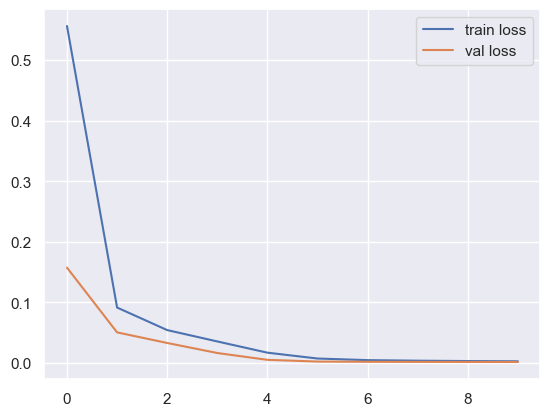

In [31]:
# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.legend()
plt.show()

# finetuning - evaluate

0.00109 0.02561


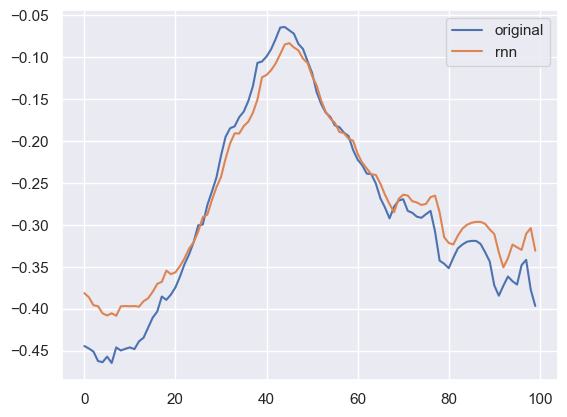

In [40]:
# load best pretraining model
best_model_path = 'expt4/rnn.pt'
rnn_model = RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
rnn_model.load_state_dict(torch.load(best_model_path,map_location=device))
rnn_model.eval()

# latent_vector = pretraining_model.get_latent_vector(X_test.to(device))
predictions = rnn_model(X_test.to(device))
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.plot(y[-100:],label='original')
plt.plot(pred[-100:],label='rnn')
plt.legend()
plt.show()

0.002389 0.035506


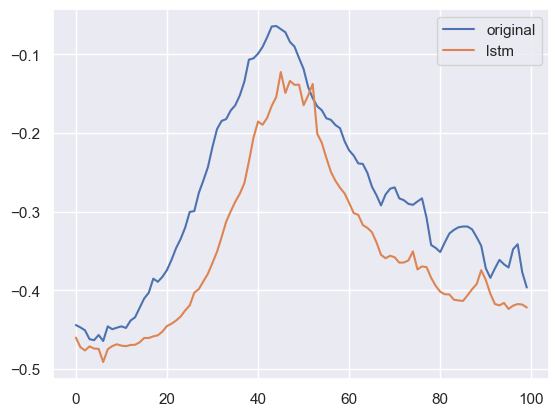

In [41]:
# load best pretraining model
best_model_path = 'expt4/lstm.pt'
rnn_model = LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
rnn_model.load_state_dict(torch.load(best_model_path,map_location=device))
rnn_model.eval()

# latent_vector = pretraining_model.get_latent_vector(X_test.to(device))
predictions = rnn_model(X_test.to(device))
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.plot(y[-100:],label='original')
plt.plot(pred[-100:],label='lstm')
plt.legend()
plt.show()

0.001552 0.030265


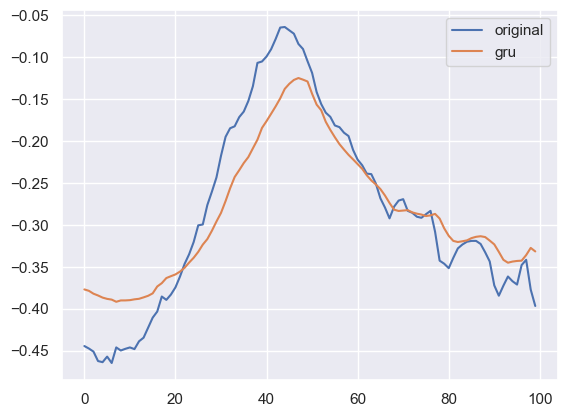

In [42]:
# load best pretraining model
best_model_path = 'expt4/gru.pt'
rnn_model = GRU(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
rnn_model.load_state_dict(torch.load(best_model_path,map_location=device))
rnn_model.eval()

# latent_vector = pretraining_model.get_latent_vector(X_test.to(device))
predictions = rnn_model(X_test.to(device))
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.plot(y[-100:],label='original')
plt.plot(pred[-100:],label='gru')
plt.legend()
plt.show()

0.002553 0.03913
0.002469 0.036635
0.002454 0.036878


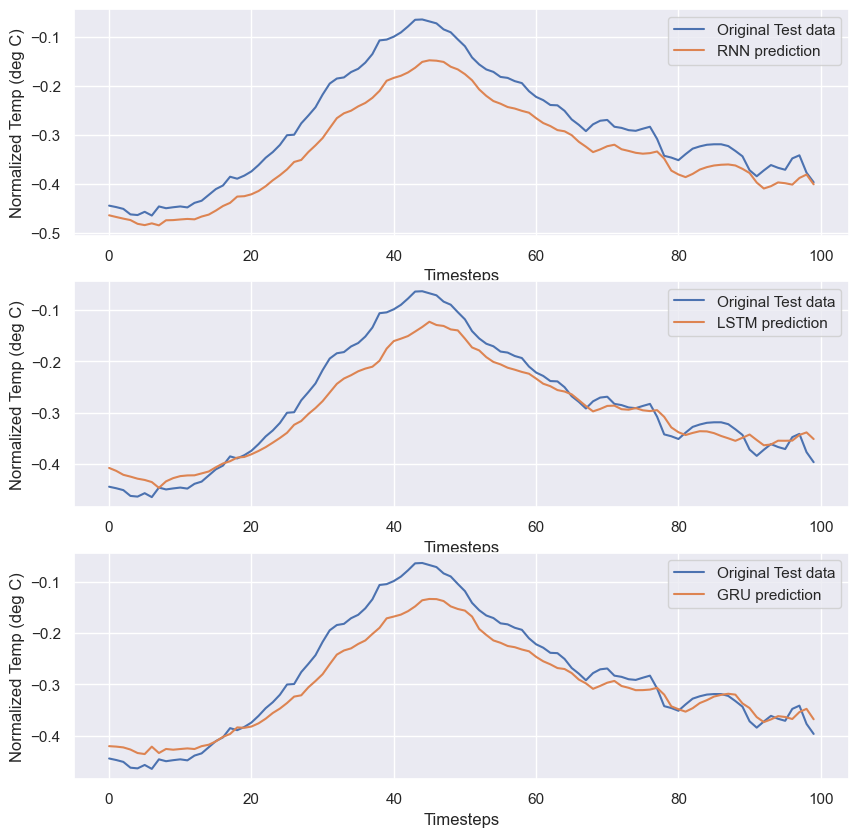

In [30]:
fig,ax=plt.subplots(3,1,figsize=(10,10))

# load best pretraining model
best_model_path = 'expt2/rnn.pt'
rnn_model = RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
rnn_model.load_state_dict(torch.load(best_model_path,map_location=device))
rnn_model.eval()

# latent_vector = pretraining_model.get_latent_vector(X_test.to(device))
predictions = rnn_model(X_test.to(device))
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.subplot(3,1,1)
plt.plot(y[-100:],label='Original Test data')
plt.plot(pred[-100:],label='RNN prediction')
plt.xlabel('Timesteps')
plt.ylabel('Normalized Temp (deg C)')
plt.legend()


# load best pretraining model
best_model_path = 'expt2/lstm.pt'
rnn_model = LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
rnn_model.load_state_dict(torch.load(best_model_path,map_location=device))
rnn_model.eval()

# latent_vector = pretraining_model.get_latent_vector(X_test.to(device))
predictions = rnn_model(X_test.to(device))
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.subplot(3,1,2)
plt.plot(y[-100:],label='Original Test data')
plt.plot(pred[-100:],label='LSTM prediction')
plt.xlabel('Timesteps')
plt.ylabel('Normalized Temp (deg C)')
plt.legend()



# load best pretraining model
best_model_path = 'expt2/gru.pt'
rnn_model = GRU(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
rnn_model.load_state_dict(torch.load(best_model_path,map_location=device))
rnn_model.eval()

# latent_vector = pretraining_model.get_latent_vector(X_test.to(device))
predictions = rnn_model(X_test.to(device))
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.subplot(3,1,3)
plt.plot(y[-100:],label='Original Test data')
plt.plot(pred[-100:],label='GRU prediction')
plt.xlabel('Timesteps')
plt.ylabel('Normalized Temp (deg C)')
plt.legend()

plt.savefig('expt2.png')

plt.show()